In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pandas as pd
import os
import torch
import torch.optim as optim

from helper_fn import *
from networks import *
%load_ext autoreload
%autoreload 2

torch.Size([20000, 101, 2]) torch.Size([5000, 101, 2])


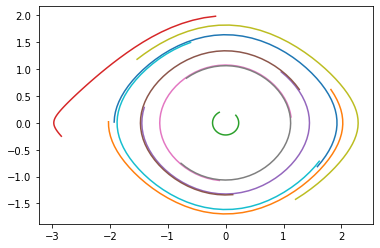

In [2]:
train_data = torch.tensor(np.load("data/pendulum_train.npy")).float()
val_data = torch.tensor(np.load("data/pendulum_val.npy")).float()
print(train_data.shape, val_data.shape)

for i in np.random.randint(0, len(val_data), 10):
    plt.plot(val_data[i, :50, 0], val_data[i, :50, 1])
plt.show()

In [4]:
from helper_fn import *
from networks import *

RESET_LOGS = False

CPT = "model-denis-50-1579727340"

if len(CPT)!=0:
    MODEL_NAME = "{}".format(CPT)
else:
    MODEL_NAME = "model-denis-50-{}".format(int(time.time()))
    
BATCH_SIZE = 100
EPOCHS = 500

SAVE_METHOD = 'Best'
ROOT_DIR = "logs/denis_pendulum"
CPT_DIR = "models/{}.pt".format(CPT)
FIG_DIR = os.path.join(ROOT_DIR, "figures/{}".format(MODEL_NAME))
DIST_DIR = os.path.join(ROOT_DIR, "dists/{}".format(MODEL_NAME))
EIG_DIR = os.path.join(ROOT_DIR, "eigens/{}".format(MODEL_NAME))

CONFIG_DIR = os.path.join(ROOT_DIR, 'model_configs.csv')
SAVE_FIG = True
SAVE_DIST = True
SAVE_EIG = True

if not os.path.isdir(FIG_DIR) and SAVE_FIG:
    os.mkdir(FIG_DIR)
    
if not os.path.isdir(DIST_DIR) and SAVE_DIST:
    os.mkdir(DIST_DIR)
    
if not os.path.isdir(EIG_DIR) and SAVE_EIG:
    os.mkdir(EIG_DIR)

log_dir = os.path.join(ROOT_DIR, 'logs.csv')
model_dir = os.path.join(ROOT_DIR, 'models/{}.pt'.format(MODEL_NAME))

encoder_shape = [2, 4, 8, 16, 32, 32, 64, 64, 58]
aux_shape =     [2, 4, 8, 16, 32, 32, 64, 64, 58, encoder_shape[0]+encoder_shape[-1]]

params = {'encoder_shape': encoder_shape, 'aux_shape': aux_shape,'n_shifts': 50,
          'state_loss': 10, 'latent_loss': 5, 'reg_loss': 1e-6, 'inf_loss': 1e-3}

meta_df = save_configs2(MODEL_NAME, params, CONFIG_DIR)

if len(CPT)!=0:
    print("Load from checkpoint: {}".format(CPT_DIR))
    model = torch.load(os.path.join(ROOT_DIR, CPT_DIR), map_location=torch.device('cpu'))
    model.params = params
else:
    print("Initializing new model {}".format(MODEL_NAME))
    model = DENIS(params)
# load data frame
df = load_df(log_dir, RESET_LOGS)

# initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.00001)

Load from checkpoint: models/model-denis-50-1579727340.pt
Loading logs from logs/denis_pendulum/logs.csv


In [ ]:
for epoch in range(EPOCHS):
    pbar = tqdm(range(0, len(train_data), BATCH_SIZE))
    for i in pbar:
        model = model.train()
        batch_X = train_data[i:i+BATCH_SIZE]
        model.zero_grad()
        enc_gt, enc_traj, ko = model(batch_X)

        loss, state_mse, latent_mse, inf_mse = koopman_loss(enc_gt, enc_traj, params)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            model = model.eval()
            val_enc_gt, val_enc_traj, ko = model(val_data)
            val_loss, val_state_mse, val_latent_mse, val_inf_mse = koopman_loss(val_enc_gt, val_enc_traj, params)

            # save to dataframe
            df.loc[len(df)+1] = [MODEL_NAME, epoch, float(loss), float(val_loss), 
                                 float(state_mse), float(val_state_mse), float(latent_mse), float(val_latent_mse),
                                 float(inf_mse), float(val_inf_mse)]

            # update progress bar
            pbar.set_description("loss: {:.4f}, val_loss: {:.4f}, state_mse: {:.4f}".format(loss, 
                                                                                            val_loss, 
                                                                                            state_mse))
            pbar.refresh()
            
        if i % 2000 == 0:
            model = model.eval()
            if SAVE_FIG:
                fig_dir = os.path.join(FIG_DIR, "{}.png".format(int(time.time())))
                plot_val(val_data, model, val_state_mse, fig_dir)
                
        if i % 5000 == 0:
            model = model.eval()
            
            if SAVE_EIG:
                enc_gt, enc_traj, ko = model(train_data)
                ko = ko.detach().numpy()
                enc_traj = enc_traj.detach()[:, 0, :].numpy()

                fig_dir = os.path.join(EIG_DIR, "{}.png".format(int(time.time())))
                plot_eigen_func(ko, enc_traj, train_data, fig_dir=fig_dir)
            
            if SAVE_DIST:
                dist_dir = os.path.join(DIST_DIR, "{}.png".format(int(time.time())))
                plot_layers(model.named_parameters(), val_state_mse, dist_dir, n_rows=4)
            
            
        saver(model, model_dir, df, MODEL_NAME, float(val_loss), 'All')
            
    df.to_csv(log_dir, index=False)
    increment_epoch_config(MODEL_NAME, CONFIG_DIR)

In [6]:
torch.save(model, "/Users/luxiaoding/Desktop/DKoopman/logs/denis_pendulum/models/model-denis-50-1579727340.pt")

/anaconda3/envs/DKoopman/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DENIS. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda3/envs/DKoopman/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [11]:
enc_gt, enc_traj, _ = model(train_data)
enc_gt = enc_gt.detach()
enc_traj = enc_traj.detach()
enc_traj_0 = enc_traj[:, 0, :].numpy()

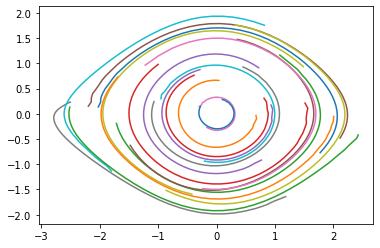

In [13]:
for i in range(20):
    plt.plot(enc_traj[i+100, :, 0].numpy(), enc_gt[i+100, :, 1].numpy())